<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## Kerry's MSDS453 - Research Assignment 02 - Classification and Clustering

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’. 

In [1]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

from time import asctime
import unicodedata

In [2]:
the_time = asctime().replace(" ", "").replace(":", "")

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br> 
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Drive

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### NLTK Downloads

In [4]:
# Only run this once, they will be downloaded.
#nltk.download('stopwords',quiet=True)
#nltk.download('wordnet',quiet=True)
#nltk.download('punkt',quiet=True)
#nltk.download('omw-1.4',quiet=True)

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [5]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [6]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.8.3


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

## Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix 
1. Latent Semantic Analysis 
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

from sklearn.decomposition import TruncatedSVD

def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

In [8]:
def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    """
    Creating the term dictionary of our courpus, 
    where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    """
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix # vector of unique terms per doc for all docs; try with tfitdf? doc2vec?
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100
#                        ,words=10
                       )
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index
            
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    
    # mess with alpha 0.5, 0.6
    # beta 0.1
    # more words
    # higher alpha documents contain more similar topic contents
    
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,alpha='auto' # what does auto do
#                        ,eta='auto' #??
                        ,decay=0.1
                        ,iterations=100 # mess with this; min 100
                        ,random_state=23
                        ,chunksize=1000
                        ,passes=20) # min 20; epochs?
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)
    
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

## Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest

In [9]:
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title, clusters, frame

def classifiers(x, y, model_type, cv = 3):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
    #can define cv value for cross validation.
    
    #function returns the train test split scores of each model.
    
    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions) 
    return accy

## Visualization Utility Functions

In [10]:
def plot_lsa(number_of_topics, words):

    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_tfidf_matrix(cluster_title, clusters, TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'gray', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                      5:'red', 6:'darksalmon', 7:'sienna'
                     }

    #set up cluster names using a dict.  
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point
    
    print(cluster_dict[name])
    
    plt.savefig(f"/Users/kerry/Projects/msds453/{the_time}_cluster.png")

In [11]:
def strip_accents(STR):
    return ''.join(c for c in unicodedata.normalize('NFD', STR)
                   if unicodedata.category(c) != 'Mn')

def clean_doc(doc): 
    """
    Given a string doc,
    this function cleans the doc
    of . . .
    non-ascii chars
    punctuation
    anything other than lower case words
    non-alphabetic tokens
    stop words
    tokens shorter than length 3
    stem, lemma are also options
    returns the list of tokens.
    """
    doc = strip_accents(doc) # replaces non-ascii with utf-friendly chars
    doc = re.sub(r'[^\x00-\x7F]', '', doc) # removes any remaining non-ascii chars
    
    tokens = doc.split() # set the tone
    
    # punctuation situation
    sub_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [sub_punc.sub('', w) for w in tokens]
    
    # alpha
    tokens = [word for word in tokens if word.isalpha()]
    
    # shorties
    tokens = [word for word in tokens if len(word) > 3]
    
    # capitalization
    tokens = [word.lower() for word in tokens]
    
    # stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    
    # lemma
    return tokens # tokens is a list

## Loading the Class Corpus

In [12]:
#read in class corpus csv into python
data=pd.read_csv(r'~/Projects/msds453/MSDS_453_Public/MSDS453_ClassCorpus/ClassCorpus_Final_v3_20220710.csv')

#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
#final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
final_processed_text = [' '.join(x) for x in data['processed_text']]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text']#.tolist()

In [13]:
data['processed_text']

0      [jimmy, fallons, screen, career, even, gets, s...
1      [getting, nominated, chicago, making, boxoffic...
2      [queen, latifah, handily, walked, away, show, ...
3      [jimmy, fallon, leaves, osaturday, night, live...
4      [taxiecasts, jimmyefallon, officer, andy, wash...
                             ...                        
195    [inception, makes, average, moviegoer, feel, s...
196    [basic, idea, story, good, money, spectacular,...
197    [unless, call, movie, masterpiece, damn, word,...
198    [reading, amazing, reviews, seeing, score, bes...
199    [shame, movie, rated, highly, imdb, tell, movi...
Name: processed_text, Length: 200, dtype: object

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

In [14]:
#type(data['processed_text'][0])

In [15]:
theString = data['Text'].iloc[3]

In [16]:
[' '.join(xyz) for xyz in data['processed_text']]==[' '.join(x) for x in data['processed_text'].tolist()]

True

In [17]:
data

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,processed_text
0,160,ARE_Doc1_Taxi,Jimmy Fallon's big screen career may be over b...,ARE_Doc1_Taxi,ARE,Action,Negative,Taxi,"[jimmy, fallons, screen, career, even, gets, s..."
1,161,ARE_Doc2_Taxi,"After getting nominated for ""Chicago"" and maki...",ARE_Doc2_Taxi,ARE,Action,Positive,Taxi,"[getting, nominated, chicago, making, boxoffic..."
2,162,ARE_Doc3_Taxi,Queen Latifah handily walked away with the sho...,ARE_Doc3_Taxi,ARE,Action,Negative,Taxi,"[queen, latifah, handily, walked, away, show, ..."
3,163,ARE_Doc4_Taxi,So Jimmy Fallon leaves ÒSaturday Night LiveÓ a...,ARE_Doc4_Taxi,ARE,Action,Negative,Taxi,"[jimmy, fallon, leaves, osaturday, night, live..."
4,164,ARE_Doc5_Taxi,TaxiÊcasts JimmyÊFallon as Officer Andy Washbu...,ARE_Doc5_Taxi,ARE,Action,Negative,Taxi,"[taxiecasts, jimmyefallon, officer, andy, wash..."
...,...,...,...,...,...,...,...,...,...
195,85,MGB_Doc6_Inception,Inception makes the average moviegoer feel sma...,MGB_Doc6_Inception,MGB,Action,Negative,Inception,"[inception, makes, average, moviegoer, feel, s..."
196,86,MGB_Doc7_Inception,"You have this basic idea and the story, they a...",MGB_Doc7_Inception,MGB,Action,Negative,Inception,"[basic, idea, story, good, money, spectacular,..."
197,87,MGB_Doc8_Inception,Unless you call this movie a masterpiece. Then...,MGB_Doc8_Inception,MGB,Action,Negative,Inception,"[unless, call, movie, masterpiece, damn, word,..."
198,88,MGB_Doc9_Inception,After reading all the amazing reviews and seei...,MGB_Doc9_Inception,MGB,Action,Negative,Inception,"[reading, amazing, reviews, seeing, score, bes..."


### K-Means Experiment with 3D Plot

## Exploritory Data Analysis

In [18]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)


def get_corpus_df(path):
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

@dataclass
class Document:
    doc_id: str
    text: str

In [19]:
CORPUS_PATH = '~/Projects/msds453/MSDS_453_Public/MSDS453_ClassCorpus/ClassCorpus_Final_v3_20220710.csv' # copy?
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

In [20]:
corpus_df.shape

(200, 9)

In [21]:
corpus_df.head().T

Doc_ID,40,41,42,43,44
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...,There is a certain mindless pleasure in the Fa...,"No, you dont need to have seen Olympus Has F..."
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Student Name,KCM,KCM,KCM,KCM,KCM
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42,Action_Angel Has Fallen_N_43,Action_Angel Has Fallen_N_44
Doc_ID,40,41,42,43,44


In [22]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 40 to 199
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB
None


In [23]:
print(corpus_df['Movie Title'].unique())

['Angel Has Fallen' 'Inception' 'No Time To Die' 'Taken' 'Taxi'
 'Despicable Me 3' 'Dirty Grandpa' 'Holmes and Watson' 'Legally Blonde'
 'The Lost City' 'Drag me to hell' 'Fresh' 'It Chapter Two'
 'The Toxic Avenger' 'US' 'Batman' 'Equilibrium' 'Minority Report'
 'Oblivion' 'Pitch Black']


## Latent Semantic Analysis - Research Number of Topics and Number of Words

### Plotting 2 topics and 10 words

[(0, '-0.422*"film" + -0.287*"movie" + -0.201*"like" + -0.173*"time" + -0.139*"even" + -0.132*"would" + -0.127*"action" + -0.125*"much" + -0.104*"first" + -0.101*"movies"'), (1, '-0.396*"anderton" + -0.282*"minority" + -0.259*"report" + 0.210*"movie" + -0.202*"precrime" + -0.194*"spielberg" + -0.158*"technology" + -0.139*"future" + -0.123*"precogs" + 0.117*"equilibrium"')]


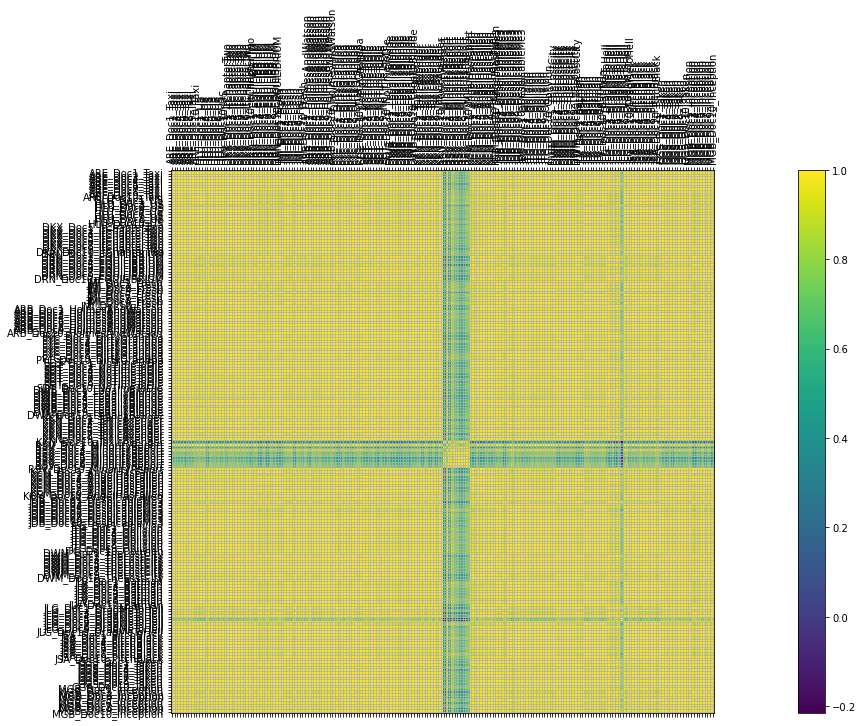

In [24]:
model_2topic_10words = plot_lsa(2, 10)

### Plotting 6 topics and 10 words

[(0, '-0.422*"film" + -0.287*"movie" + -0.201*"like" + -0.173*"time" + -0.139*"even" + -0.132*"would" + -0.127*"action" + -0.125*"much" + -0.104*"first" + -0.101*"movies"'), (1, '-0.396*"anderton" + -0.282*"minority" + -0.259*"report" + 0.210*"movie" + -0.202*"precrime" + -0.194*"spielberg" + -0.158*"technology" + -0.139*"future" + -0.123*"precogs" + 0.117*"equilibrium"'), (2, '-0.336*"bond" + 0.307*"equilibrium" + 0.201*"matrix" + 0.145*"preston" + 0.133*"film" + -0.114*"time" + 0.108*"christian" + 0.101*"guns" + 0.098*"would" + 0.095*"cleric"'), (3, '0.563*"bond" + 0.266*"time" + -0.243*"film" + 0.136*"craig" + 0.115*"bonds" + 0.109*"equilibrium" + 0.098*"james" + 0.097*"craigs" + -0.094*"batman" + 0.092*"anderton"'), (4, '0.503*"film" + -0.484*"movie" + 0.205*"bond" + -0.125*"lost" + 0.107*"batman" + -0.103*"movies" + -0.100*"elle" + -0.097*"like" + -0.081*"anderton" + -0.080*"loretta"'), (5, '-0.471*"batman" + -0.263*"joker" + -0.182*"bruce" + -0.174*"itos" + -0.168*"city" + -0.154

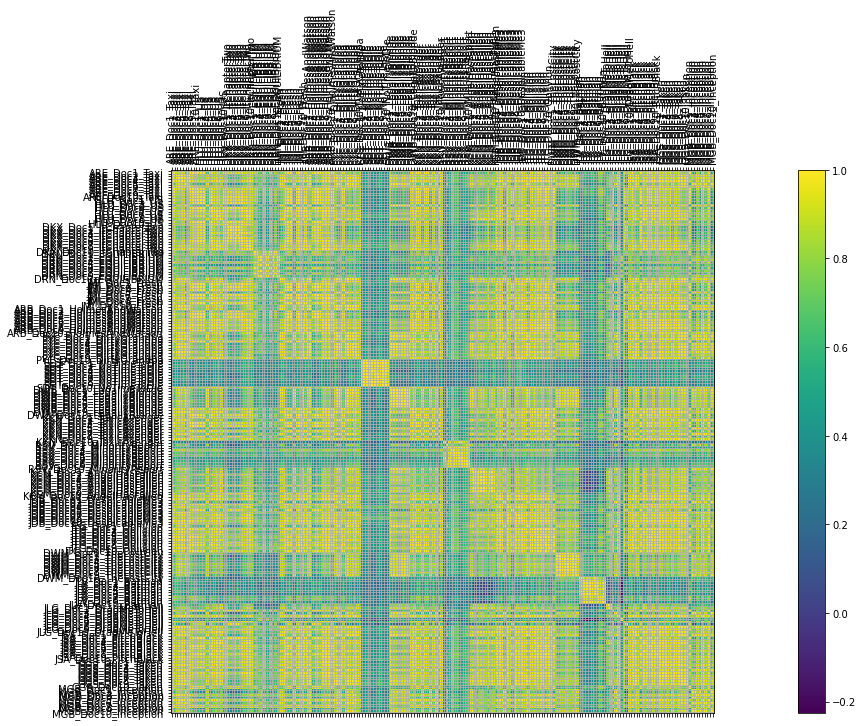

In [25]:
model_6topic_10words = plot_lsa(6, 10)

### Plotting 20 topics and 10 words

[(0, '-0.422*"film" + -0.287*"movie" + -0.201*"like" + -0.173*"time" + -0.139*"even" + -0.132*"would" + -0.127*"action" + -0.125*"much" + -0.104*"first" + -0.101*"movies"'), (1, '0.396*"anderton" + 0.282*"minority" + 0.259*"report" + -0.210*"movie" + 0.202*"precrime" + 0.194*"spielberg" + 0.158*"technology" + 0.139*"future" + 0.123*"precogs" + -0.117*"equilibrium"'), (2, '-0.336*"bond" + 0.307*"equilibrium" + 0.201*"matrix" + 0.145*"preston" + 0.133*"film" + -0.114*"time" + 0.108*"christian" + 0.101*"guns" + 0.098*"would" + 0.095*"cleric"'), (3, '0.563*"bond" + 0.266*"time" + -0.243*"film" + 0.136*"craig" + 0.115*"bonds" + 0.109*"equilibrium" + 0.098*"james" + 0.097*"craigs" + -0.094*"batman" + 0.092*"anderton"'), (4, '0.503*"film" + -0.484*"movie" + 0.205*"bond" + -0.125*"lost" + 0.107*"batman" + -0.103*"movies" + -0.100*"elle" + -0.097*"like" + -0.081*"anderton" + -0.080*"loretta"'), (5, '0.471*"batman" + 0.263*"joker" + 0.182*"bruce" + 0.174*"itos" + 0.168*"city" + 0.154*"keaton" + 

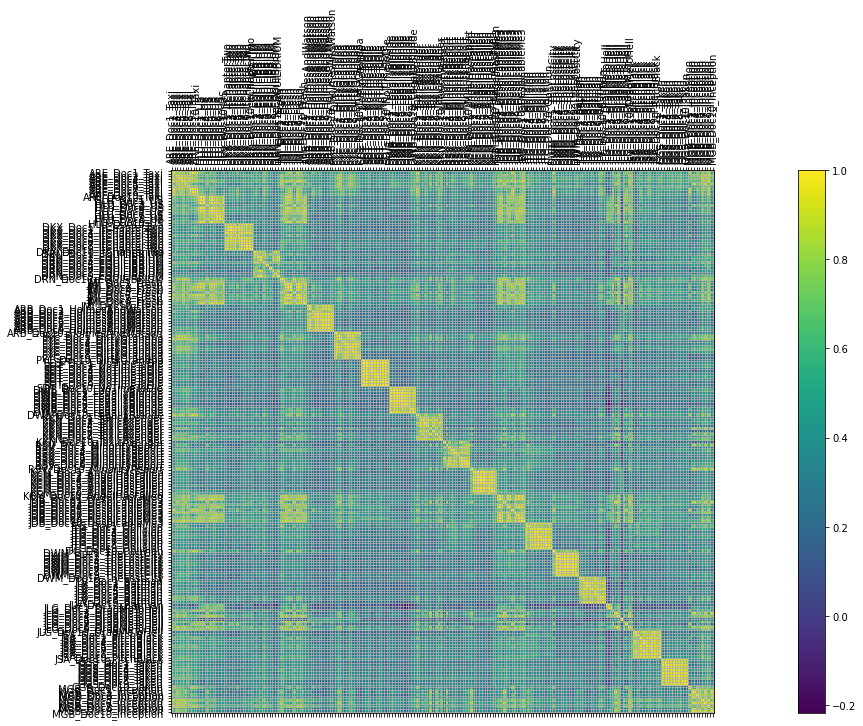

In [26]:
model_20topic_10words = plot_lsa(20, 10)
# corpus with 20 movies and 10 documents each
# plotting & producing an lsa model with 20 topics 10 words each

# here's ur first topic
# (0, '-0.422*"film" + -0.287*"movie" + -0.201*"like" + -0.173*"time" + -0.139*"even" + -0.132*"would" + -0.127*"action" + -0.125*"much" + -0.104*"first" + -0.101*"movies"')
 
# is it describing 1 movie maybe? eh? idk

# try cleaning the data and removing the high frequency words as stop words
# peele should be same as peeles

### Compare LSA Model Coherence

In [27]:
topics = [7, 2, 10] # 6
#topics = [idx for idx in range(3, 11)]

coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'7 topic 10 words':coherence_values[0], # 42%
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2],}   #40%

print(coherence)

# higher coherence will allot easier interpretation of the topic
# higher coherence should enable more intuitive topics

#print(coherence_values)

[(0, '-0.422*"film" + -0.287*"movie" + -0.201*"like" + -0.173*"time" + -0.139*"even" + -0.132*"would" + -0.127*"action" + -0.125*"much" + -0.104*"first" + -0.101*"movies"'), (1, '-0.396*"anderton" + -0.282*"minority" + -0.259*"report" + 0.210*"movie" + -0.202*"precrime" + -0.194*"spielberg" + -0.158*"technology" + -0.139*"future" + -0.123*"precogs" + 0.117*"equilibrium"'), (2, '-0.336*"bond" + 0.307*"equilibrium" + 0.201*"matrix" + 0.145*"preston" + 0.133*"film" + -0.114*"time" + 0.108*"christian" + 0.101*"guns" + 0.098*"would" + 0.095*"cleric"'), (3, '-0.563*"bond" + -0.266*"time" + 0.243*"film" + -0.136*"craig" + -0.115*"bonds" + -0.109*"equilibrium" + -0.098*"james" + -0.097*"craigs" + 0.094*"batman" + -0.092*"anderton"'), (4, '0.503*"film" + -0.484*"movie" + 0.205*"bond" + -0.125*"lost" + 0.107*"batman" + -0.103*"movies" + -0.100*"elle" + -0.097*"like" + -0.081*"anderton" + -0.080*"loretta"'), (5, '-0.471*"batman" + -0.263*"joker" + -0.182*"bruce" + -0.174*"itos" + -0.168*"city" + 

In [28]:
print(coherence)

{'7 topic 10 words': 0.2981176238310583, '2 topic 10 words': 0.25864703285012913, '20 topic 10 words': 0.3469510815677103}


## Latent Dirichlet Allocation - Research Number of Topics and Number of Words

In [29]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=4
words=20
#####################################

[(0, '0.005*"lost" + 0.005*"movie" + 0.004*"taken" + 0.004*"like" + 0.004*"bryan" + 0.004*"city" + 0.004*"loretta" + 0.003*"film" + 0.003*"alan" + 0.003*"bullock" + 0.003*"neeson" + 0.003*"action" + 0.002*"even" + 0.002*"well" + 0.002*"tatum" + 0.002*"paris" + 0.002*"character" + 0.002*"jack" + 0.002*"much" + 0.002*"time"'), (1, '0.010*"film" + 0.009*"movie" + 0.005*"like" + 0.004*"even" + 0.004*"time" + 0.003*"first" + 0.003*"much" + 0.003*"would" + 0.003*"horror" + 0.003*"also" + 0.003*"story" + 0.002*"well" + 0.002*"good" + 0.002*"movies" + 0.002*"many" + 0.002*"scene" + 0.002*"people" + 0.002*"make" + 0.002*"something" + 0.002*"characters"'), (2, '0.006*"film" + 0.006*"bond" + 0.005*"time" + 0.004*"like" + 0.004*"movie" + 0.003*"batman" + 0.003*"even" + 0.002*"would" + 0.002*"make" + 0.002*"much" + 0.002*"jack" + 0.002*"also" + 0.002*"world" + 0.002*"films" + 0.002*"action" + 0.002*"planet" + 0.002*"never" + 0.002*"character" + 0.002*"years" + 0.002*"black"'), (3, '0.009*"film" + 0

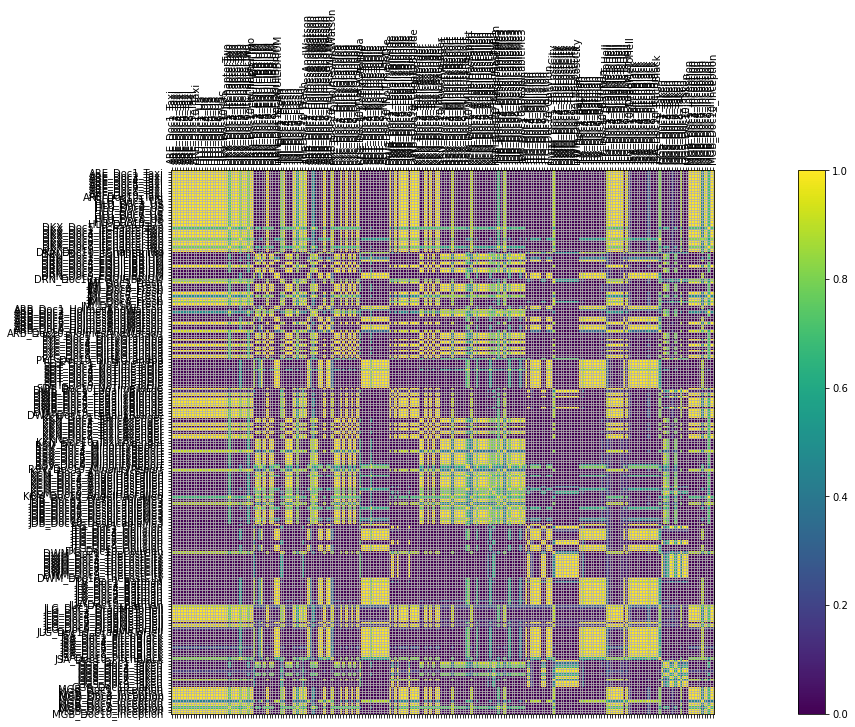

In [30]:
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model( processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

### Compare LDA Model Coherence

In [31]:
#topics = [idx for idx in range(3, 11)]
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,
                                                                t,
                                                                10)


    coherence_model_lda = CoherenceModel(model=ldamodel,
                                         dictionary=dictionary,
                                         texts=processed_text,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    
coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]} # 36%

print(coherence)

# higher coherence will allot easier interpretation of the topic
# higher coherence should enable more intuitive topics

[(0, '0.004*"like" + 0.004*"movie" + 0.004*"lost" + 0.003*"city" + 0.003*"alan" + 0.003*"loretta" + 0.003*"taken" + 0.002*"tatum" + 0.002*"bullock" + 0.002*"movies"'), (1, '0.011*"movie" + 0.011*"film" + 0.007*"like" + 0.004*"time" + 0.003*"even" + 0.003*"would" + 0.003*"story" + 0.003*"horror" + 0.003*"first" + 0.003*"well"'), (2, '0.006*"film" + 0.006*"batman" + 0.005*"time" + 0.004*"bond" + 0.004*"like" + 0.003*"movie" + 0.003*"would" + 0.003*"joker" + 0.003*"even" + 0.003*"black"'), (3, '0.008*"film" + 0.005*"movie" + 0.004*"fallen" + 0.004*"like" + 0.003*"banning" + 0.003*"even" + 0.003*"angel" + 0.003*"mike" + 0.003*"grandpa" + 0.003*"dirty"'), (4, '0.008*"film" + 0.006*"holmes" + 0.005*"watson" + 0.004*"pennywise" + 0.004*"chapter" + 0.004*"losers" + 0.003*"ferrell" + 0.003*"itas" + 0.003*"even" + 0.003*"bill"'), (5, '0.007*"film" + 0.006*"movie" + 0.004*"like" + 0.004*"time" + 0.004*"action" + 0.003*"even" + 0.003*"bond" + 0.003*"much" + 0.003*"equilibrium" + 0.003*"films"')]
[

In [32]:
#coherence_values

## NLP Supervised and Unsupervised Learning Methods:
1. K-Means Clustering (Unsupervised)
2. Support Vector Machines (SVMs) (Supervised)
3. (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
4. Logistic Regression (Supervised)

## Cluster Model Research: KMeans, SVM, Logistic, Naive Bayes, Randomforest

### Generate TF-IDF For Analysis

In [33]:
def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix #,words

In [34]:
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

### K-Means Experiment with 3D Plot

['JDB_Doc06_DespicableMe3', 'MGB_Doc1_Inception', 'MGB_Doc2_Inception', 'MGB_Doc3_Inception', 'MGB_Doc4_Inception', 'MGB_Doc5_Inception', 'MGB_Doc6_Inception', 'MGB_Doc7_Inception']


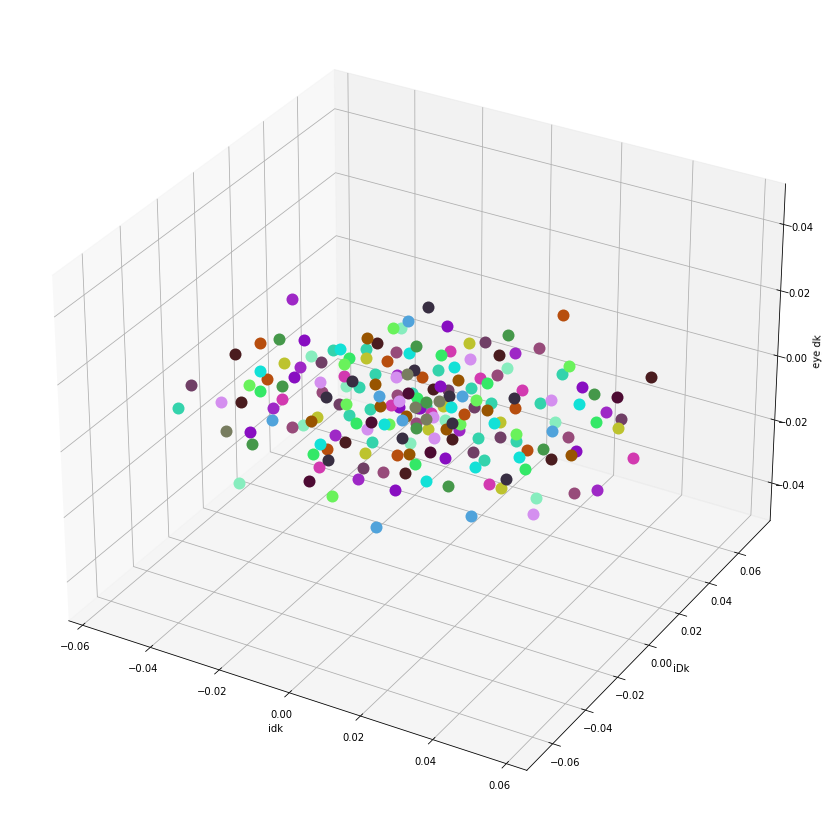

In [50]:
cluster_title, clusters, k_means_df = k_means(titles, tfidf_matrix, k = 20)
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
dist = cosine_similarity(tfidf_matrix) # 1 - cosine_similarity(TFIDF_matrix) | dist = 1 + cosine_similarity(TFIDF_matrix)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'gray', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna'
                 }

#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')

for name, group in groups:

    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)

    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=color, 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.set_xlabel('idk')
ax.set_ylabel('iDk')
ax.set_zlabel('eye dk')

ax.legend(loc='best')      #show legend with only 1 point

print(cluster_dict[name])
the_time = asctime().replace(" ", "").replace(":", "")
plt.savefig(f"/Users/kerry/Projects/msds453/{the_time}_cluster.png")


patches, labels = ax.get_legend_handles_labels()
# Get rid of the legend on the first plot, so it is only drawn on the separate figure
ax.get_legend().remove()  

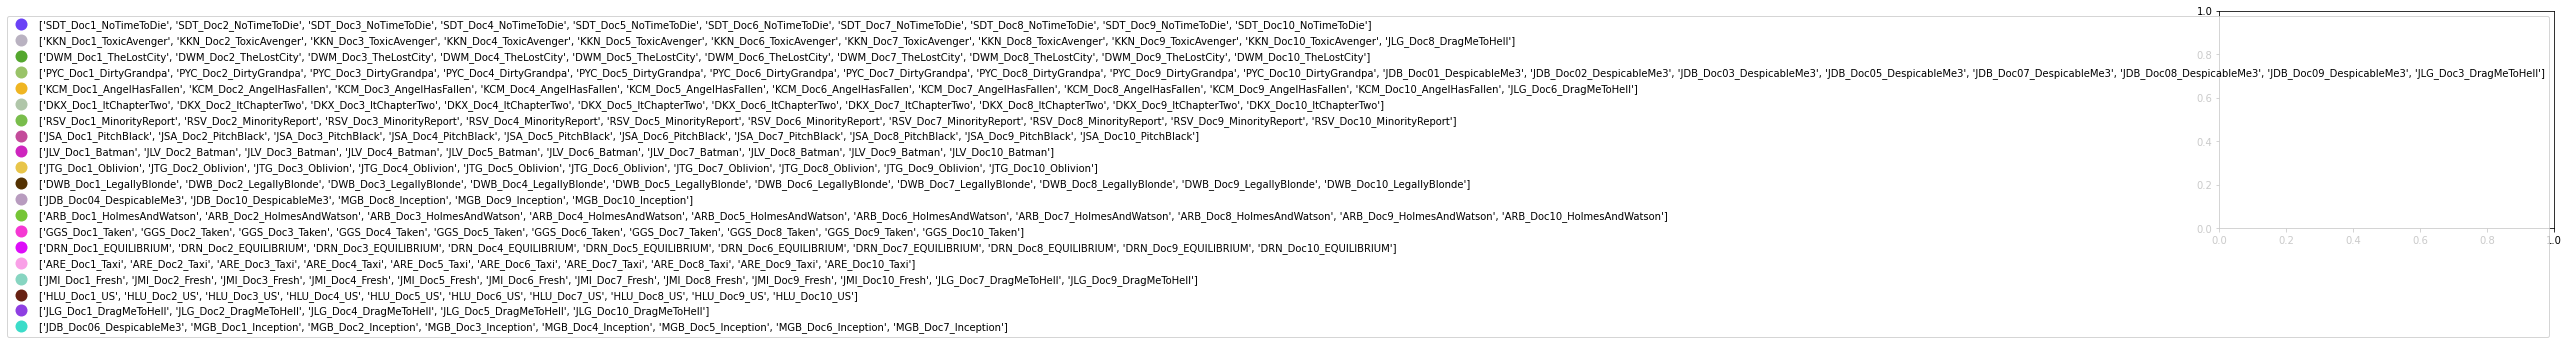

In [49]:
# get handles and labels for reuse
label_params = ax.get_legend_handles_labels() 

figl, axl = plt.subplots()
axl.legend(patches, labels , loc='best')

In [44]:
from gensim.test.utils import common_dictionary, common_corpus
from gensim.models import LsiModel
from sklearn.decomposition import TruncatedSVD

model = LsiModel(common_corpus, id2word=common_dictionary)
vectorized_corpus = model[common_corpus]  # vectorize input copus in BoW format

common_corpus

len(set(data['processed_text'].tolist()[70])) #uniueqs

thing = [corpora.Dictionary(data['processed_text']).doc2bow(doc) for doc in data['processed_text']]

len(thing)

len(thing[70])

len(thing[70][0])

[corpora.Dictionary(data['processed_text']).doc2bow(doc) for doc in data['processed_text']]

#tfidf_matrix

LSA = TruncatedSVD(n_components=10)
LSA.fit(tfidf_matrix)
LSA.components_

array([[ 1.07763431e-03,  1.60270329e-03,  9.95223918e-04, ...,
         9.21297611e-04,  3.84091836e-04,  8.42609135e-03],
       [-5.79142622e-04, -1.01923257e-03, -7.14918462e-04, ...,
        -1.76248850e-03, -1.34976985e-04, -4.21039279e-03],
       [-3.55695603e-04, -1.07498894e-03, -9.86537770e-04, ...,
         1.20136213e-03, -6.30372962e-04, -8.40563265e-03],
       ...,
       [ 7.31322648e-03,  1.38802384e-02,  1.13203386e-02, ...,
        -1.71588940e-03, -3.73018433e-04, -1.21852363e-02],
       [-2.92339150e-03, -5.62529095e-03, -4.63831087e-03, ...,
        -7.52958310e-04,  6.87261023e-05, -7.48836886e-03],
       [-1.14756549e-05, -5.68996358e-04, -2.93117356e-04, ...,
         5.33978255e-04,  2.05451891e-04,  7.19732078e-03]])

In [ ]:
tfidf_matrix

tfidf_matrix.dtypes

tfidf_matrix[tfidf_matrix > 0.0].count()

_.sum()

tfidf_matrix.shape[0]*tfidf_matrix.shape[1]

3236400

3236400-3173713

tfidf_matrix[tfidf_matrix == 0.0].count().sum() # conclusion : this is a sparse matrix

In [ ]:
3173713/3236400

In [ ]:
tfidf_matrix[tfidf_matrix == 0.0].count().sum()

In [ ]:
(tfidf_matrix[tfidf_matrix == 0.0].count().sum())/(tfidf_matrix.shape[0]*tfidf_matrix.shape[1])

### KMeans Clustering

<div class="alert alert-block alert-success">
    <b>sklearn.cluster.KMeans</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br><br>
<b>KMeans Default Parameters</b>:<br>
    class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    </div>

In [ ]:
cluster_title, clusters, k_means_df = k_means(titles, tfidf_matrix, k = 4)

### Access Each Cluster - Changing Dictionary KeyValue from 0 to k

In [ ]:
cluster_title[2]

In [ ]:
plot_tfidf_matrix(cluster_title, clusters, tfidf_matrix)

### Generate Labels for Supervised Learning Models

In [ ]:
pos_neg_labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(pos_neg_labels)

In [ ]:
data['GenreCode'] = data['Genre of Movie'].astype("category").cat.codes
genre_labels = data['GenreCode']
print(genre_labels)

### Naive Bayes

<div class="alert alert-block alert-success">
    <b>Naive Bayes</b>:<br> 
https://scikit-learn.org/stable/modules/naive_bayes.html<br><br>
    Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.
    </div>

In [ ]:
classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', cv=len(tfidf_matrix)-1)

In [ ]:
classifiers(tfidf_matrix, genre_labels, 'naive_bayes', cv=len(tfidf_matrix)-1)

In [ ]:
# dark purple means it didnt converge; it's just random
# not rly any underlying __ concepts being extracted based on model

In [ ]:
# tdm matrix as input